In [1]:
import os
import spacy
import numpy as np
import pandas as pd
import datasets
import torch
import evaluate

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from huggingface_hub import get_full_repo_name, Repository, notebook_login, create_repo
from transformers import AutoModelForTokenClassification, AutoTokenizer, DataCollatorForTokenClassification, pipeline, Trainer, TrainingArguments, get_scheduler
from torch.utils.data import DataLoader
from torch.optim import AdamW
# from accelerate import Accelerator
from tqdm.auto import tqdm


In [2]:
# Path to data
TEXT_FOLDER = './data/CADEC.v2/cadec/text/'
OG_ANN_FOLDER = './data/CADEC.v2/cadec/original/'

In [3]:
#####################################################
# ------------------- FUNCTIONS ------------------- #
#####################################################

# Function to read text from a .txt file
def read_text(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        return file.read()

# Function to read annotations from a .ann file
def read_annotations(file_path):
    annotations = []

    with open(file_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        if not line.startswith('#'):
            parts = line.split('\t')

            # Get only the important information
            information = parts[1].split()

            # Get values from info
            label = information[0]
            # Semicolon problem not solved
            start_values = [value for value in information[1].split(';')]
            end_values = [value for value in information[2].split(';')]

            for start, end in zip(start_values, end_values):
                annotations.append({"start": int(start), "end": int(end), "label": label})

    return annotations

# Update tags based on the annotations
def annotate_text(doc, annotations):
    tags = ["O"] * len(doc)
    for annotation in annotations:
        start, end, label = annotation["start"], annotation["end"], annotation["label"]
        start_token = None
        for i, token in enumerate(doc):
            if start_token is None and token.idx >= start:
                start_token = i
            if token.idx + len(token) >= end and start_token is not None:
                for j in range(start_token, i + 1):
                    if j == start_token:
                        tags[j] = f"B-{label}"
                    else:
                        tags[j] = f"I-{label}"
                break
    return tags

# Function that aligns tokens with labels
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else label2id[labels[word_id]]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as the previous token
            label = label2id[labels[word_id]]
            # If the label is B-XXX, we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

# Function that tokenizees and aligns the labels with the tokens
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

# count total amount each entity type is in the training set
def count_entities(dataset):
    entity_count = {}
    for doc in dataset:
        for tag in doc['ner_tags']:
            if tag in entity_count:
                entity_count[tag] += 1
            else:
                entity_count[tag] = 1
    return entity_count

# Compute metrics for the training evaluation
# def compute_metrics(eval_preds):
#     logits, labels = eval_preds
#     predictions = np.argmax(logits, axis=-1)

#     # Remove ignored index (special tokens) and convert to labels
#     true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
#     true_predictions = [
#         [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
#         for prediction, label in zip(predictions, labels)
#     ]
#     all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
#     return {
#         "precision": all_metrics["overall_precision"],
#         "recall": all_metrics["overall_recall"],
#         "f1": all_metrics["overall_f1"],
#         "accuracy": all_metrics["overall_accuracy"],
#     }

# Improved compute metrics for evaluation during training
def compute_metrics(eval_preds):
# def improved_compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    entity_metrics = {entity: {"precision": 0, "recall": 0, "f1": 0} for entity in label_names}

    for entity in label_names:
        #  precision, recall, and F1 per the entity type
        true_entity_labels = [1 if entity in labels else 0 for labels in true_labels]
        predicted_entity_labels = [1 if entity in labels else 0 for labels in true_predictions]

        entity_metrics[entity]["precision"] = precision_score(true_entity_labels, predicted_entity_labels)
        entity_metrics[entity]["recall"] = recall_score(true_entity_labels, predicted_entity_labels)
        entity_metrics[entity]["f1"] = f1_score(true_entity_labels, predicted_entity_labels)

    # flatten, list of lists to list
    flat_true_labels = [label for labels in true_labels for label in labels]
    flat_true_predictions = [label for labels in true_predictions for label in labels]

    # macro and micro average F1 scores
    macro_f1 = np.mean([entity_metrics[entity]["f1"] for entity in label_names])
    micro_f1 = f1_score(flat_true_labels, flat_true_predictions, average='micro')

    all_metrics = {
        "entity_metrics": entity_metrics,
        "macro_f1": macro_f1,
        "micro_f1": micro_f1,
    }

    return all_metrics

# Function that pos process the predictions and returns true labels and true preds
def postprocess(predictions, labels):
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_labels, true_predictions

# Convert annotations into IOB

In [4]:
# Path to data
TEXT_FOLDER = './data/CADEC.v2/cadec/text/'
OG_ANN_FOLDER = './data/CADEC.v2/cadec/original/'

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Get a list of all text files in the folder
text_files = [f for f in os.listdir(TEXT_FOLDER) if f.endswith(".txt")]

# Initialize lists to store data
data_arr = []

# Loop through each text file
for text_file in text_files:
    # print(text_file)
    # Build file paths
    txt_file_path = os.path.join(TEXT_FOLDER, text_file)
    ann_file_path = os.path.join(OG_ANN_FOLDER, text_file.replace(".txt", ".ann"))

    # Read text from the .txt file
    text = read_text(txt_file_path)

    # Read annotations from the .ann file
    annotations = read_annotations(ann_file_path)

    # Process the text with spaCy
    doc = nlp(text)

    # Perform the annotation loop
    tags_array = annotate_text(doc, annotations)

    # Create a word by word array
    words_array = [token.text for token in doc]

    # Store the data for this document
    data_arr.append({"tokens": words_array, "ner_tags": tags_array})

# Convert the list of dictionaries to a pandas dataframe
df = pd.DataFrame(data_arr)

# Print the dataframe
# df


# Transform data into desired HuggingFace format

In [5]:
#####################################################
# -- Pandas DataFrame to HuggingFace DatasetDict -- #
#####################################################

# Split data into train, val & test sets
data, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(data, test_size=0.2)

# Convert to dataset dictionaries
train_dataframe = pd.DataFrame({
    'id': train.index.values.astype(str),
    'tokens': train.tokens.values,
    'ner_tags': train.ner_tags.values
})
dev_dataframe = pd.DataFrame({
    'id': val.index.values.astype(str),
    'tokens': val.tokens.values,
    'ner_tags': val.ner_tags.values
})
test_dataframe = pd.DataFrame({
    'id': test.index.values.astype(str),
    'tokens': test.tokens.values,
    'ner_tags': test.ner_tags.values
})

# From dictionaries to DatasetDict
train_dataset = datasets.Dataset.from_dict(train_dataframe)
dev_dataset = datasets.Dataset.from_dict(dev_dataframe)
test_dataset = datasets.Dataset.from_dict(test_dataframe)

# Join into one
raw_data = datasets.DatasetDict({'train': train_dataset, 'validation': dev_dataset, 'test': test_dataset})

In [6]:
raw_data

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 200
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 250
    })
})

In [13]:
#####################################################
# ------------ Statistics from dataset ------------ #
#####################################################

train_count = count_entities(raw_data['train'])
entity_count = count_entities(raw_data['train'])
test_count = count_entities(raw_data['test'])
val_count = count_entities(raw_data['validation'])

entity_count

# calculate for val and test set and then sum
entity_count_val = count_entities(raw_data['validation'])
entity_count_test = count_entities(raw_data['test'])

for key in entity_count_val:
    entity_count[key] += (entity_count_val[key] + entity_count_test[key])
    
print ( "all datasets: \n", entity_count) 
print ( "train dataset: \n", train_count) 

all datasets: 
 {'B-ADR': 5952, 'O': 109813, 'I-ADR': 8669, 'B-Symptom': 269, 'I-Symptom': 261, 'B-Finding': 425, 'I-Finding': 394, 'B-Drug': 1799, 'B-Disease': 282, 'I-Disease': 191, 'I-Drug': 226}
train dataset: 
 {'B-ADR': 3867, 'O': 71638, 'I-ADR': 5675, 'B-Symptom': 147, 'I-Symptom': 145, 'B-Finding': 251, 'I-Finding': 241, 'B-Drug': 1149, 'B-Disease': 187, 'I-Disease': 127, 'I-Drug': 136}


In [18]:
# remove 'O' from all counts
entity_count.pop('O')
train_count.pop('O')
val_count.pop('O')

KeyError: 'O'

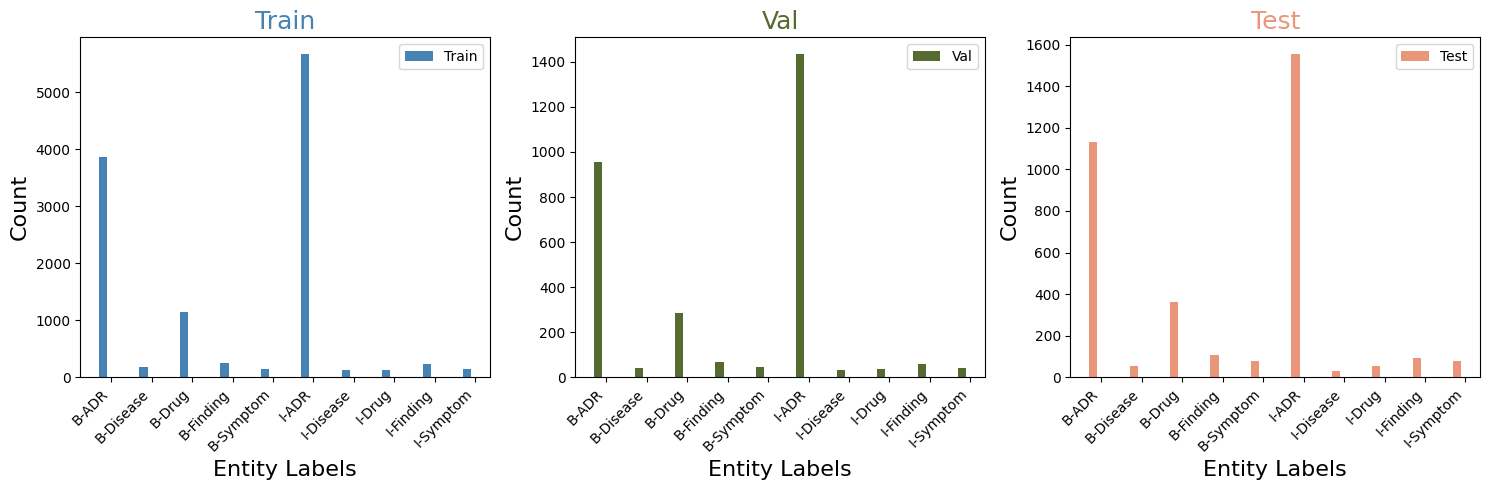

In [29]:
import matplotlib.pyplot as plt
import numpy as np

entity_labels = list(train_count.keys())
entity_labels.sort()

bar_width = 0.2

train_positions = np.arange(len(entity_labels))
val_positions = train_positions + bar_width
test_positions = val_positions + bar_width

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for ax, data, title, color in zip(axs, [train_count, val_count, test_count], ['Train', 'Val', 'Test'], ['steelblue', 'darkolivegreen', 'darksalmon']):
    ax.bar(train_positions, [data[label] for label in entity_labels], width=bar_width, color=color, label=title)
    ax.set_title(title, fontsize=18, color=color)
    ax.set_xlabel('Entity Labels', fontsize=16)
    ax.set_ylabel('Count', fontsize=16)
    ax.set_xticks(val_positions)
    ax.set_xticklabels(entity_labels, rotation=45, ha='right')
    ax.legend()

plt.tight_layout()
plt.show()


{'B-ADR': 5952, 'B-Symptom': 269, 'B-Finding': 425, 'B-Drug': 1799, 'B-Disease': 282}
{'I-ADR': 8669, 'I-Symptom': 261, 'I-Finding': 394, 'I-Disease': 191, 'I-Drug': 226}


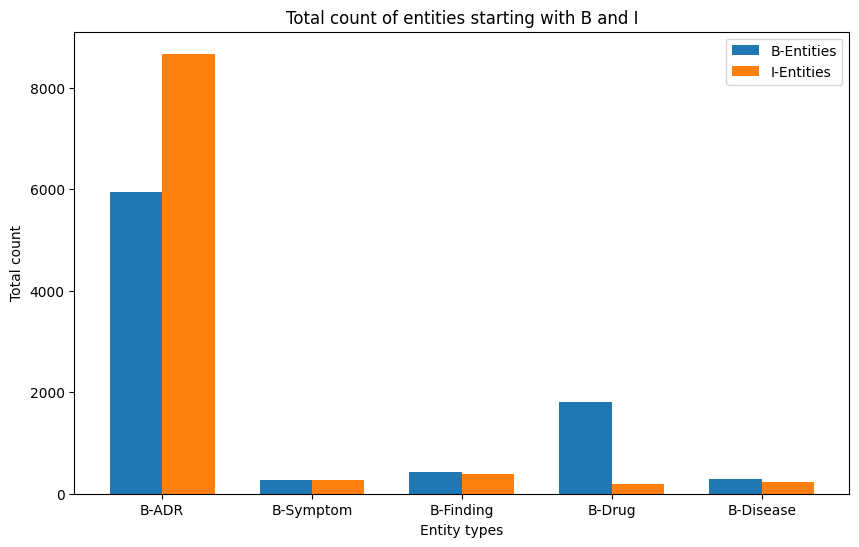

In [33]:
# plot total amount of labels starting with B compared to labels starting with I

count_b_entities = {key: value for key, value in entity_count.items() if key.startswith('B-')}
count_i_entities = {key: value for key, value in entity_count.items() if key.startswith('I-')}

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35

print(count_b_entities)
print(count_i_entities)
b_bars = ax.bar(range(len(count_b_entities)), list(count_b_entities.values()), bar_width, label='B-Entities')
i_bars = ax.bar([x + bar_width for x in range(len(count_i_entities))], list(count_i_entities.values()), bar_width, label='I-Entities')

ax.set_xlabel('Entity types')
ax.set_ylabel('Total count')
ax.set_title('Total count of entities starting with B and I')
ax.set_xticks([x + bar_width/2 for x in range(len(count_b_entities))])
ax.set_xticklabels(count_b_entities.keys())
ax.legend()


plt.show()

# Tokenize data

In [12]:
#####################################################
# ----------------- Get tokenizer ----------------- #
#####################################################

# Get tokenizer from checkpint
model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Set labels with Id
label_names = ['O', 'B-ADR', 'I-ADR',
               'B-Disease', 'I-Disease',
               'B-Drug', 'I-Drug',
               'B-Finding', 'I-Finding',
               'B-Symptom', 'I-Symptom']

id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

tokenized_datasets = raw_data.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_data["train"].column_names,
)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

# Train Model

In [12]:
#####################################################
# ------------------- Get Model ------------------- #
#####################################################

# Get data collector with the previously defined tokenizer
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Get metric
metric = evaluate.load("seqeval")

# Get model from checkpoint
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

# Number of labels the model has
model.config.num_labels

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


11

In [13]:
#####################################################
# ------------- Train Base-line Model ------------- #
#####################################################

# Set training arguments
args = TrainingArguments(
    "bert-finetuned-ner",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=True,
)

# Set trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# Train
trainer.train()

# Push to hub (saving the train in HuggingFace)
trainer.push_to_hub(commit_message="Training complete")

  0%|          | 0/300 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/25 [00:00<?, ?it/s]

c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1471

{'eval_loss': 0.302517294883728, 'eval_entity_metrics': {'O': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-ADR': {'precision': 0.9653179190751445, 'recall': 0.9597701149425287, 'f1': 0.962536023054755}, 'I-ADR': {'precision': 0.9608938547486033, 'recall': 0.9942196531791907, 'f1': 0.9772727272727273}, 'B-Disease': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-Disease': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'B-Drug': {'precision': 0.9907407407407407, 'recall': 0.9553571428571429, 'f1': 0.9727272727272727}, 'I-Drug': {'precision': 0.990990990990991, 'recall': 0.9821428571428571, 'f1': 0.9865470852017937}, 'B-Finding': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-Finding': {'precision': 1.0, 'recall': 0.025, 'f1': 0.04878048780487806}, 'B-Symptom': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-Symptom': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}, 'eval_macro_f1': 0.4498057814601297, 'eval_micro_f1': 0.9056520198440822, 'eval_runtime': 93.8888, 'eval_samples_per_se

  0%|          | 0/25 [00:00<?, ?it/s]

c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'O': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}

{'eval_loss': 0.26452377438545227, 'eval_entity_metrics': {'O': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-ADR': {'precision': 0.9666666666666667, 'recall': 1.0, 'f1': 0.983050847457627}, 'I-ADR': {'precision': 0.9555555555555556, 'recall': 0.9942196531791907, 'f1': 0.9745042492917847}, 'B-Disease': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-Disease': {'precision': 0.5333333333333333, 'recall': 0.25806451612903225, 'f1': 0.34782608695652173}, 'B-Drug': {'precision': 0.9910714285714286, 'recall': 0.9910714285714286, 'f1': 0.9910714285714286}, 'I-Drug': {'precision': 0.9910714285714286, 'recall': 0.9910714285714286, 'f1': 0.9910714285714286}, 'B-Finding': {'precision': 0.6666666666666666, 'recall': 0.17777777777777778, 'f1': 0.2807017543859649}, 'I-Finding': {'precision': 0.4583333333333333, 'recall': 0.275, 'f1': 0.34374999999999994}, 'B-Symptom': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-Symptom': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}, 'eval_macro_f1': 0.5374

  0%|          | 0/25 [00:00<?, ?it/s]

c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'O': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}

{'eval_loss': 0.2650657296180725, 'eval_entity_metrics': {'O': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-ADR': {'precision': 0.9613259668508287, 'recall': 1.0, 'f1': 0.9802816901408451}, 'I-ADR': {'precision': 0.9608938547486033, 'recall': 0.9942196531791907, 'f1': 0.9772727272727273}, 'B-Disease': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-Disease': {'precision': 0.5294117647058824, 'recall': 0.2903225806451613, 'f1': 0.375}, 'B-Drug': {'precision': 0.9910714285714286, 'recall': 0.9910714285714286, 'f1': 0.9910714285714286}, 'I-Drug': {'precision': 1.0, 'recall': 0.9910714285714286, 'f1': 0.9955156950672646}, 'B-Finding': {'precision': 0.6190476190476191, 'recall': 0.28888888888888886, 'f1': 0.3939393939393939}, 'I-Finding': {'precision': 0.41935483870967744, 'recall': 0.325, 'f1': 0.36619718309859156}, 'B-Symptom': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-Symptom': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}, 'eval_macro_f1': 0.5526616470991137, 'eval_micro_f1'

CommitInfo(commit_url='https://huggingface.co/Bramve/bert-finetuned-ner/commit/cfdcd864f89584c212d773629d3daecc9d0f8c35', commit_message='Training complete', commit_description='', oid='cfdcd864f89584c212d773629d3daecc9d0f8c35', pr_url=None, pr_revision=None, pr_num=None)

CRF


In [19]:
import os
import spacy
import numpy as np
import pandas as pd
import datasets
import torch
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from huggingface_hub import get_full_repo_name, Repository, notebook_login, create_repo
from transformers import AutoModelForTokenClassification, AutoTokenizer, DataCollatorForTokenClassification, pipeline, Trainer, TrainingArguments, get_scheduler
from TorchCRF import CRF
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm.auto import tqdm

model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

label_names = ['O', 'B-ADR', 'I-ADR',
               'B-Disease', 'I-Disease',
               'B-Drug', 'I-Drug',
               'B-Finding', 'I-Finding',
               'B-Symptom', 'I-Symptom']

id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

tokenized_datasets = raw_data.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_data["train"].column_names,
)

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

# add CRF layer to the model
model.crf = CRF(num_labels=model.config.num_labels)
model.config.num_labels

args = TrainingArguments(
    "bert-finetuned-ner-CRF",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

trainer.train()

trainer.push_to_hub(commit_message="Training complete")

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/300 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/25 [00:00<?, ?it/s]

c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1471

{'eval_loss': 0.28709399700164795, 'eval_entity_metrics': {'O': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-ADR': {'precision': 0.9502762430939227, 'recall': 0.9608938547486033, 'f1': 0.9555555555555556}, 'I-ADR': {'precision': 0.9361702127659575, 'recall': 0.9943502824858758, 'f1': 0.9643835616438357}, 'B-Disease': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-Disease': {'precision': 0.5, 'recall': 0.034482758620689655, 'f1': 0.06451612903225806}, 'B-Drug': {'precision': 0.9516129032258065, 'recall': 0.959349593495935, 'f1': 0.9554655870445343}, 'I-Drug': {'precision': 0.9918032786885246, 'recall': 0.983739837398374, 'f1': 0.9877551020408164}, 'B-Finding': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-Finding': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'B-Symptom': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-Symptom': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}, 'eval_macro_f1': 0.4479705395742727, 'eval_micro_f1': 0.9077959809539181, 'eval_runtime': 114.0973, 'e

  0%|          | 0/25 [00:00<?, ?it/s]

c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'O': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-ADR': {'precision': 0.9516129032258065, 'recall': 0.9888268156424581, 'f1': 0.9698630136986301}, 'I-ADR': {'precision': 0.9411764705882353, 'recall': 0.9943502824858758, 'f1': 0.9670329670329672}, 'B-Disease': {'precision': 0.5555555555555556, 'recall': 0.16129032258064516, 'f1': 0.25}, 'I-Disease

{'eval_loss': 0.24961765110492706, 'eval_entity_metrics': {'O': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-ADR': {'precision': 0.9516129032258065, 'recall': 0.9888268156424581, 'f1': 0.9698630136986301}, 'I-ADR': {'precision': 0.9411764705882353, 'recall': 0.9943502824858758, 'f1': 0.9670329670329672}, 'B-Disease': {'precision': 0.5555555555555556, 'recall': 0.16129032258064516, 'f1': 0.25}, 'I-Disease': {'precision': 0.5454545454545454, 'recall': 0.41379310344827586, 'f1': 0.47058823529411764}, 'B-Drug': {'precision': 0.9834710743801653, 'recall': 0.967479674796748, 'f1': 0.9754098360655739}, 'I-Drug': {'precision': 0.991869918699187, 'recall': 0.991869918699187, 'f1': 0.991869918699187}, 'B-Finding': {'precision': 0.75, 'recall': 0.08333333333333333, 'f1': 0.15}, 'I-Finding': {'precision': 0.56, 'recall': 0.4117647058823529, 'f1': 0.4745762711864407}, 'B-Symptom': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-Symptom': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}, 'eval_mac

  0%|          | 0/25 [00:00<?, ?it/s]

c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'O': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-ADR': {'precision': 0.9518716577540107, 'recall': 0.994413407821229, 'f1': 0.9726775956284153}, 'I-ADR': {'precision': 0.9411764705882353, 'recall': 0.9943502824858758, 'f1': 0.9670329670329672}, 'B-Disease': {'precision': 0.6923076923076923, 'recall': 0.2903225806451613, 'f1': 0.4090909090909091}

{'eval_loss': 0.24656683206558228, 'eval_entity_metrics': {'O': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-ADR': {'precision': 0.9518716577540107, 'recall': 0.994413407821229, 'f1': 0.9726775956284153}, 'I-ADR': {'precision': 0.9411764705882353, 'recall': 0.9943502824858758, 'f1': 0.9670329670329672}, 'B-Disease': {'precision': 0.6923076923076923, 'recall': 0.2903225806451613, 'f1': 0.4090909090909091}, 'I-Disease': {'precision': 0.5, 'recall': 0.4482758620689655, 'f1': 0.4727272727272727}, 'B-Drug': {'precision': 0.9836065573770492, 'recall': 0.975609756097561, 'f1': 0.9795918367346939}, 'I-Drug': {'precision': 0.991869918699187, 'recall': 0.991869918699187, 'f1': 0.991869918699187}, 'B-Finding': {'precision': 0.7777777777777778, 'recall': 0.19444444444444445, 'f1': 0.3111111111111111}, 'I-Finding': {'precision': 0.5555555555555556, 'recall': 0.4411764705882353, 'f1': 0.49180327868852464}, 'B-Symptom': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-Symptom': {'precision': 0.0,

CommitInfo(commit_url='https://huggingface.co/Bramve/bert-finetuned-ner-CRF/commit/b47e8f043a6c8f0883328d4cb345e775a7de2012', commit_message='Training complete', commit_description='', oid='b47e8f043a6c8f0883328d4cb345e775a7de2012', pr_url=None, pr_revision=None, pr_num=None)

# BIlstm-crf

In [42]:
model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

label_names = ['O', 'B-ADR', 'I-ADR',
               'B-Disease', 'I-Disease',
               'B-Drug', 'I-Drug',
               'B-Finding', 'I-Finding',
               'B-Symptom', 'I-Symptom']

id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

tokenized_datasets = raw_data.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_data["train"].column_names,
)

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

#add bilstm layer to the model
model.bilstm = torch.nn.LSTM(model.config.hidden_size, model.config.hidden_size, num_layers=1, bidirectional=True, batch_first=True)
model.config.num_labels

args = TrainingArguments(
    "bert-finetuned-ner-bilstm",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

trainer.train()

trainer.push_to_hub(commit_message="Training complete")

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/300 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/25 [00:00<?, ?it/s]

c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1471

{'eval_loss': 0.2884244918823242, 'eval_entity_metrics': {'O': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-ADR': {'precision': 0.9510869565217391, 'recall': 0.9776536312849162, 'f1': 0.9641873278236915}, 'I-ADR': {'precision': 0.9408602150537635, 'recall': 0.9887005649717514, 'f1': 0.9641873278236914}, 'B-Disease': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-Disease': {'precision': 0.625, 'recall': 0.1724137931034483, 'f1': 0.2702702702702703}, 'B-Drug': {'precision': 0.9754098360655737, 'recall': 0.967479674796748, 'f1': 0.9714285714285714}, 'I-Drug': {'precision': 1.0, 'recall': 0.991869918699187, 'f1': 0.9959183673469388}, 'B-Finding': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-Finding': {'precision': 1.0, 'recall': 0.029411764705882353, 'f1': 0.05714285714285715}, 'B-Symptom': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-Symptom': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}, 'eval_macro_f1': 0.47483042925782004, 'eval_micro_f1': 0.9090872407392462, 'eval_runti

  0%|          | 0/25 [00:00<?, ?it/s]

c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'O': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-ADR': {'precision': 0.9516129032258065, 'recall': 0.9888268156424581, 'f1': 0.9698630136986301}, 'I-ADR': {'precision': 0.9411764705882353, 'recall': 0.9943502824858758, 'f1': 0.9670329670329672}, 'B-Disease': {'precision': 0.7, 'recall': 0.22580645161290322, 'f1': 0.3414634146341463}, 'I-Disease'

{'eval_loss': 0.25115445256233215, 'eval_entity_metrics': {'O': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-ADR': {'precision': 0.9516129032258065, 'recall': 0.9888268156424581, 'f1': 0.9698630136986301}, 'I-ADR': {'precision': 0.9411764705882353, 'recall': 0.9943502824858758, 'f1': 0.9670329670329672}, 'B-Disease': {'precision': 0.7, 'recall': 0.22580645161290322, 'f1': 0.3414634146341463}, 'I-Disease': {'precision': 0.55, 'recall': 0.3793103448275862, 'f1': 0.4489795918367347}, 'B-Drug': {'precision': 0.9916666666666667, 'recall': 0.967479674796748, 'f1': 0.9794238683127573}, 'I-Drug': {'precision': 1.0, 'recall': 0.983739837398374, 'f1': 0.9918032786885246}, 'B-Finding': {'precision': 1.0, 'recall': 0.05555555555555555, 'f1': 0.10526315789473684}, 'I-Finding': {'precision': 0.6, 'recall': 0.35294117647058826, 'f1': 0.4444444444444445}, 'B-Symptom': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-Symptom': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}, 'eval_macro_f1': 0.568024

  0%|          | 0/25 [00:00<?, ?it/s]

c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bramv\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'O': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-ADR': {'precision': 0.9516129032258065, 'recall': 0.9888268156424581, 'f1': 0.9698630136986301}, 'I-ADR': {'precision': 0.9411764705882353, 'recall': 0.9943502824858758, 'f1': 0.9670329670329672}, 'B-Disease': {'precision': 0.5882352941176471, 'recall': 0.3225806451612903, 'f1': 0.4166666666666666

{'eval_loss': 0.24407970905303955, 'eval_entity_metrics': {'O': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'B-ADR': {'precision': 0.9516129032258065, 'recall': 0.9888268156424581, 'f1': 0.9698630136986301}, 'I-ADR': {'precision': 0.9411764705882353, 'recall': 0.9943502824858758, 'f1': 0.9670329670329672}, 'B-Disease': {'precision': 0.5882352941176471, 'recall': 0.3225806451612903, 'f1': 0.41666666666666663}, 'I-Disease': {'precision': 0.5, 'recall': 0.4482758620689655, 'f1': 0.4727272727272727}, 'B-Drug': {'precision': 0.9836065573770492, 'recall': 0.975609756097561, 'f1': 0.9795918367346939}, 'I-Drug': {'precision': 0.991869918699187, 'recall': 0.991869918699187, 'f1': 0.991869918699187}, 'B-Finding': {'precision': 0.875, 'recall': 0.19444444444444445, 'f1': 0.3181818181818182}, 'I-Finding': {'precision': 0.7368421052631579, 'recall': 0.4117647058823529, 'f1': 0.5283018867924528}, 'B-Symptom': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'I-Symptom': {'precision': 0.0, 'recall': 0

CommitInfo(commit_url='https://huggingface.co/Bramve/bert-finetuned-ner-bilstm/commit/ec06e5eb7480327fc14d02f4ee82086972b44ff7', commit_message='Training complete', commit_description='', oid='ec06e5eb7480327fc14d02f4ee82086972b44ff7', pr_url=None, pr_revision=None, pr_num=None)

# Optimizing and Training with Accelerator


In [14]:
#####################################################
# ------------ Set-up with Accelerator ------------ #
#####################################################

# Replace this with your own checkpoint
model_checkpoint = 'bert-finetuned-ner-accelerate/'
token_classifier = pipeline(
    "token-classification", model=model_checkpoint, aggregation_strategy="simple"
)

# Get dataloader for train and evaluation
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], collate_fn=data_collator, batch_size=8
)

# Get model from the new pretrained checkpoint
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

# Set optimizer AdamW in this case
optimizer = AdamW(model.parameters(), lr=2e-5)

# Set accelerator
accelerator = Accelerator()

# Prepare
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(model, optimizer, train_dataloader, eval_dataloader)

# Set accelerator train parameters
num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

OSError: Incorrect path_or_model_id: 'bert-finetuned-ner-accelerate/'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

In [ ]:
#####################################################
# --------------- HuggingFace Setup --------------- #
#####################################################

# Set model and repository name
model_name = "bert-finetuned-ner-accelerate"
repo_name = get_full_repo_name(model_name)
print(f'Repo name: {repo_name}')

# Create repository
create_repo("Gorgoura/bert-finetuned-ner-accelerate", repo_type="model")

# Set ouput directory and make the repository
output_dir = "bert-finetuned-ner-accelerate"
repo = Repository(output_dir, clone_from=repo_name)

In [15]:
#####################################################
# ----------- Training with Accelerator ----------- #
#####################################################

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    for batch in eval_dataloader:
        with torch.no_grad():
            outputs = model(**batch)

        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]

        # Necessary to pad predictions and labels for being gathered
        predictions = accelerator.pad_across_processes(predictions, dim=1, pad_index=-100)
        labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

        predictions_gathered = accelerator.gather(predictions)
        labels_gathered = accelerator.gather(labels)

        true_predictions, true_labels = postprocess(predictions_gathered, labels_gathered)
        metric.add_batch(predictions=true_predictions, references=true_labels)

    results = metric.compute()
    print(
        f"epoch {epoch}:",
        {
            key: results[f"overall_{key}"]
            for key in ["precision", "recall", "f1", "accuracy"]
        },
    )

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

NameError: name 'num_training_steps' is not defined

# Evaluation

In [ ]:
#####################################################
# ------------ Evaluating the training ------------ #
#####################################################

# Initializing the trainer again, to run the evaluation
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    # eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# Evaluate the model on the test set
test_results = trainer.evaluate(eval_dataset=tokenized_datasets["test"])
test_results

In [ ]:
# Print the results and the checkpoint used
print (f"checkpoint: {model_checkpoint}")
for key, value in test_results.items():
    print(f"{key}: {value:.3f}")

# Print all entity metrics
entity_metrics = test_results["eval_entity_metrics"]
macro_f1 = test_results["eval_macro_f1"]
micro_f1 = test_results["eval_micro_f1"]

# Display the evaluation results
print("Entity Metrics:")
for entity, metrics in entity_metrics.items():
    print(f"{entity}: Precision={metrics['precision']}, Recall={metrics['recall']}, F1={metrics['f1']}")

print(f"Macro-Averaged F1: {macro_f1}")
print(f"Micro-Averaged F1: {micro_f1}")